In [76]:
import numpy as np
import json
import random
import matplotlib.pyplot as plt
from scipy.stats import moment
from itertools import permutations
from IPython.display import clear_output

# Lateness problem

## Множество требований - класс TaskSet

In [1398]:
LAMBDA = 0.01
MU = 100
SIGMA = 40
VARK = 1

def r(task):
    ind = 0
    if isinstance(task, TaskSet):
        return task.array[ind]
    return task[ind]

def p(task):
    ind = 1
    if isinstance(task, TaskSet):
        return task.array[ind]
    return task[ind]

def d(task):
    ind = 2
    if isinstance(task, TaskSet):
        return task.array[ind]
    return task[ind]

def remove(arr, elem):
    return np.delete(arr, np.where(np.in1d(arr, elem)))

class TaskSet:
    
    def __init__(self, a):
        if isinstance(a, int):
            rs = np.cumsum(np.random.exponential(scale=1/LAMBDA, size=(a,)))
            ps = np.clip(np.random.normal(MU, SIGMA, size=(a,)), a_min=0, a_max=None)
            ds = [r + VARK*moment(ps, moment=2) for r in rs]
            self.array = np.array([rs, ps, ds]).T.astype(int)
        else:
            self.array = np.copy(a)
            
    def __repr__(self):
        return "  r  |  p  |  d  \n" + str(self.array)
    
    def copy(self):
        return TaskSet(self.array)
    
    def __getitem__(self, key):
        return TaskSet(self.array[key])
    
    def __iter__(self):
        return iter(self.array)
    
    def C(self, i, tau=0):
        t = tau
        for task in self.array[:i+1]:
            if t < r(task): t = r(task)
            t += p(task)
        return t
    
    def C_max(self, tau=0):
        t = tau
        for task in self.array:
            if t < r(task): t = r(task)
            t += p(task)
        return t
    
    def L(self, i=None, tau=0):
        if i is None:
            return self.C_max(tau) - d(self[-1])
        return self.C(i, tau) - d(self[i])
    
    def L_max(self, tau=0):
        if len(self) == 0: return float('inf')
        return max([self.L(i, tau) for i, _ in enumerate(self)])
    
    def T(self, i=None, tau=0):
        return max(0, self.L(i, tau))
    
    def T_max(self, tau=0):
        return max(0, self.L_max(tau))
    
    def __len__(self):
        return len(self.array)
    
    def __eq__(self, other):
        return self.array == other
    
    def without(self, indexes):
        return TaskSet(np.delete(self.array, np.array(indexes).astype(int), axis=0))
    
    def find(self, item):
        return np.where((self.array == item).all(axis=1))[0]
    
    def transpose(self):
        return self.array.T

## Алгоритм решения двойственной задачи

In [1493]:
def dual(N, tau, B):
    if len(N.without(B)) == 0: return float('inf')
    pi_r = r(np.argsort(N, axis=0).transpose())
    bestL = N[pi_r].L(tau=tau)
    for i_k in pi_r:
        toDrop = B.copy()
        toDrop.append(i_k)
        #print(toDrop)
        s = N.without(toDrop)
        #print(s)
        if len(s) != 0:
            task_l = min(s, key=r)
            i_l = N.find(task_l)[0]
            pi_k = remove(pi_r, [i_l, i_k])
            pi_k = np.insert(pi_k, 0, i_l)
            pi_k = np.append(pi_k, i_k)
            L_k = N[pi_k].L(tau=tau)
            if L_k < bestL:
                bestL = L_k
    return bestL

## Алгоритмы проверки решения двойственной задачи

In [1400]:
def dual_brute(N, tau, B):
    """
    Dual alg bruteforce test with no respect to B
    """
    return max([min([p.L(i_k, tau) for p in map(TaskSet, permutations(N))]) for i_k, task in enumerate(N)])

In [1401]:
def dual_brute(N, tau, B):
    """
    Dual alg bruteforce test with respect to B
    """
    
    try:
        return max([min([pm.L(i_k, tau) for pm in map(TaskSet, permutations(N)) if (pm[0].array.tolist() not in N[B].array.tolist())]) for i_k, task in enumerate(N)])
    except ValueError: # todo: remove try-catch
        return float('inf')

## Класс "пример" для основного алгоритма

In [1486]:
class Instance:
    
    def __init__(self, N, tau=0, pi=[], B=[]):
        self.N = N.copy()
        self.tau = tau
        self.pi = pi.copy()
        self.B = B.copy()
        self.nu = dual(N, tau, B)
        
    def __getitem__(self, key):
        return TaskSet(self.N.array[key])
        
    def best_job(self):
        s = self.N.without(self.B)
        sn = s[r(s.transpose()) <= self.tau]
        if len(sn) == 0:
            f = min(s, key=r)
            #self.tau = r(f)
            #self.nu = dual(self.N, self.tau, self.B)
        else:
            f = min(sn, key=d)
        return self.N.find(f)[0]
    
    def L(self, i=None):
        return self[self.pi].L(i, self.tau)
    
    def T(self, i=None):
        return self[self.pi].T(i, self.tau)
        
    def L_max(self):
        return self[self.pi].L_max(self.tau)
    
    def T_max(self):
        return self[self.pi].T_max(self.tau)
    
    def __repr__(self):
        return "Instance:\n" + repr(self.N) + "\nnu  = " + str(self.nu) + "\ntau = " + str(self.tau) + "\npi  = " + str(self.pi) + "\nB   = " + str(self.B)

## Основной алгоритм
В стандартной версии начальное значение $\pi^* = \emptyset$, в модифицированной: $\pi^* = \pi^r$ - все требования в порядке неубывания моментов поступления $r_j$.

In [1488]:
def main(N, tau=0, verbose=False, modified=False):
    b_counter = 0
    #print("bi")
    instances = [Instance(N, tau)]
    #print("ai")
    if modified: bestPi = list(range(len(N)))
    else: bestPi = []
    while len(instances) > 0:
        bestInstanceIndex, bestInstance = min(enumerate(instances), key=lambda x: x[1].nu) # + N[x[1].pi].L_max(tau))
        instances.pop(bestInstanceIndex)
        f = bestInstance.best_job()
        f_data = bestInstance[f]
        N1 = bestInstance.N.without(f)
        tau1 = max(r(f_data), bestInstance.tau) + p(f_data)
        B1 = []
        pi1 = bestInstance.pi.copy()
        pi1.append(N.find(f_data)[0])
        i1 = Instance(N1, tau1, pi1, B1)
        N2 = bestInstance.N
        tau2 = bestInstance.tau
        B2 = bestInstance.B.copy()
        B2.append(N2.find(f_data)[0]) #!
        pi2 = bestInstance.pi
        i2 = Instance(N2, tau2, pi2, B2)
        instances += [i1, i2]
        b_counter += 1
        #print(i1)
        if len(pi1) == len(N):
            #print(N[bestPi].L_max(tau))
            #print(pi1)
            if N[pi1].L_max(tau) < N[bestPi].L_max(tau):
                bestPi = pi1.copy()
                if verbose: print(bestPi, '\tLmax =', N[bestPi].L_max(tau))
        #lb = len(instances)
        instances = [i for i in instances if max(i.nu, N[i.pi].L_max(tau)) < N[bestPi].L_max(tau)]
        #print(lb, len(instances))
    return bestPi, b_counter
        

## Проверка решений, предлагаемых основным алгоритмом

In [1404]:
def bruteforce(N, tau=0):
    best_L = N.L_max(tau)
    best_N = N.copy()
    for perm in permutations(N):
        s = TaskSet(perm)
        L = s.L_max(tau)
        if L < best_L:
            best_L = L
            best_N = s.copy()
    return best_L

Метод для парсинга примеров Shunji Tanaka

In [1405]:
def parse_str(s):
    s = np.array(s.replace(',', ' ').split(), dtype=int)
    s = s.reshape((len(s)//3, 3))
    return s

import glob
schedules = []
for fname in glob.glob("./tasks/*.txt"):
    file = open(fname, 'r')
    a = np.array(list(f.split() for f in file.readlines()[:-2])).astype(int)
    schedules.append(TaskSet(a))

In [1424]:
dual(s1, 0, [])

-545

In [1457]:
#s1 = TaskSet(10)
main(s1, verbose=True)

KeyboardInterrupt: 

In [1494]:
inds=1
res, c = main(schedules[inds], verbose=True)
schedules[inds][res].L_max(0)

[0, 2, 4, 5, 7, 9, 3, 6, 8, 1] 	Lmax = 20
[0, 2, 4, 3, 7, 5, 9, 6, 8, 1] 	Lmax = 13


13

In [1442]:
dual(s1, 0, [])

-456

# Тестирование

## Проверка алгоритма решения двойственной задачи
(спойлер: что-то не так)

In [1352]:
for size in range(3, 6):
    correct = 0
    incorrect = 0
    print('processing size', size, end='... ')
    for i in range(500):
        s = TaskSet(size)
        B = list(np.random.randint(0, size, size=size-1))
        tau = random.randint(0, 1000)
        #tau=0
        nu = dual(s, tau, B)
        real_nu = dual_brute(s, tau, B)
        if nu == real_nu:
            correct += 1
        else:
            raise Exception("Incorrect")
            incorrect += 1
    print(correct, "correct\t", incorrect, "incorrect")

processing size 3... 

Exception: Incorrect

## Тестирование основного алгоритма

In [1481]:
for size in range(3, 6):
    correct = 0
    incorrect = 0
    print('processing size', size, end='... ')
    for i in range(500):
        N = TaskSet(size)
        res, c = main(N)
        res = N[res].L_max()
        bruteRes = bruteforce(N)
        if bruteRes == res:
            correct += 1
        else:
            incorrect += 1
    print(correct, "correct\t", incorrect, "incorrect")

processing size 3... 500 correct	 0 incorrect
processing size 4... 500 correct	 0 incorrect
processing size 5... 500 correct	 0 incorrect


## Тестирование основного алгоритма (мод. версия)

In [1482]:
for size in range(3, 6):
    correct = 0
    incorrect = 0
    print('processing size', size, end='... ')
    for i in range(500):
        N = TaskSet(size)
        res, c = main(N, modified=True)
        res = N[res].L_max()
        bruteRes = bruteforce(N)
        if bruteRes == res:
            correct += 1
        else:
            incorrect += 1
    print(correct, "correct\t", incorrect, "incorrect")

processing size 3... 500 correct	 0 incorrect
processing size 4... 500 correct	 0 incorrect
processing size 5... 

KeyboardInterrupt: 

## Проверка производительности осн. алгоритма

In [797]:
for size in range(4, 8):
    results = {}
    for i in range(5000):
        s = TaskSet(size)
        bp, c = main(s)
        if c not in results.keys():
            results[c] = 1
        else:
            results[c] += 1
        if (i+1) % 100 == 0:
            plt.title("Количество точек ветвления для %s примеров размерности %s" % (i+1, size))
            plt.xlabel("Счётчик")
            plt.ylabel("Частота")
            plt.grid(axis='y')
            plt.bar(results.keys(), results.values(), width=1)
            plt.show()
            clear_output(wait=True)
    with open('afreq%s.json' % size, 'w') as f:
        json.dump(results, f)
    #plt.savefig('afreq%s.png' % size, dpi=300)

<Figure size 432x288 with 0 Axes>

## Проверка производительности осн. алгоритма (мод. версия)

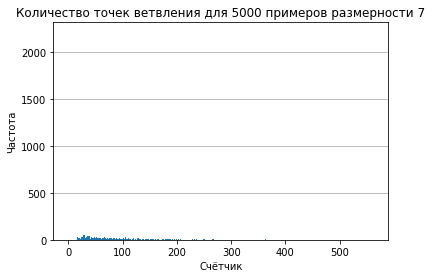

In [799]:
# !modified!
for size in range(4, 8):
    results = {}
    for i in range(5000):
        s = TaskSet(size)
        bp, c = main(s, modified=True)
        if c not in results.keys():
            results[c] = 1
        else:
            results[c] += 1
        if (i+1) % 100 == 0:
            plt.title("Количество точек ветвления для %s примеров размерности %s" % (i+1, size))
            plt.xlabel("Счётчик")
            plt.ylabel("Частота")
            plt.grid(axis='y')
            plt.bar(results.keys(), results.values(), width=1)
            plt.show()
            clear_output(wait=True)
    with open('mafreq%s.json' % size, 'w') as f:
        json.dump(results, f)
    #plt.savefig('mafreq%s.png' % size, dpi=300)

# Результаты для осн. алгоритма

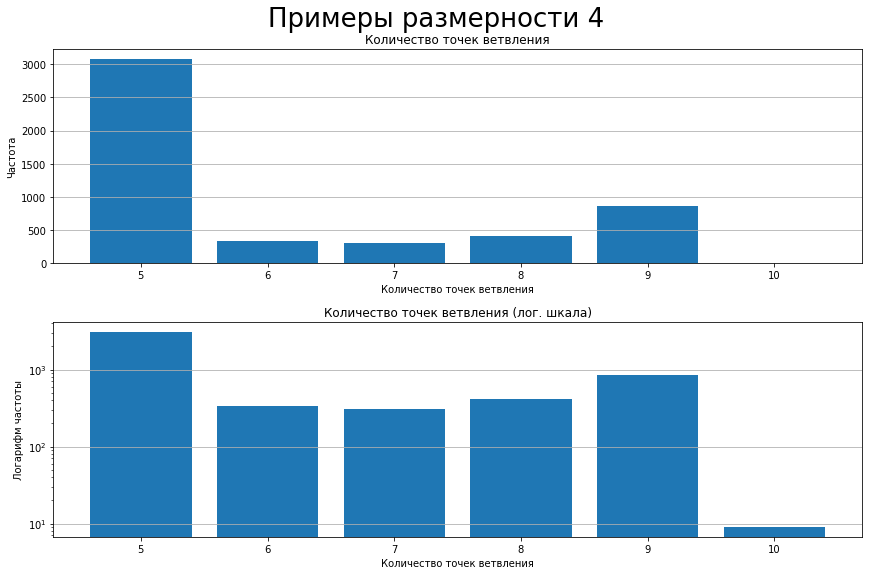

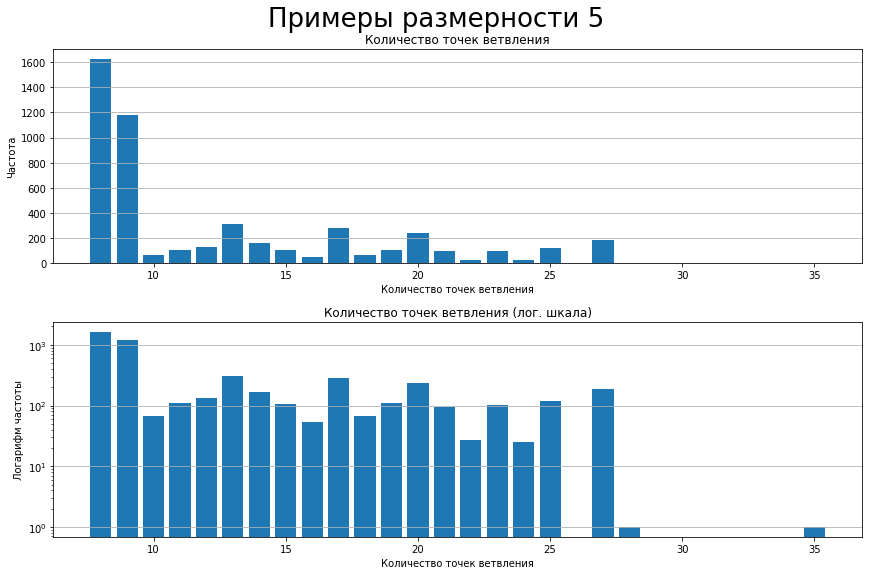

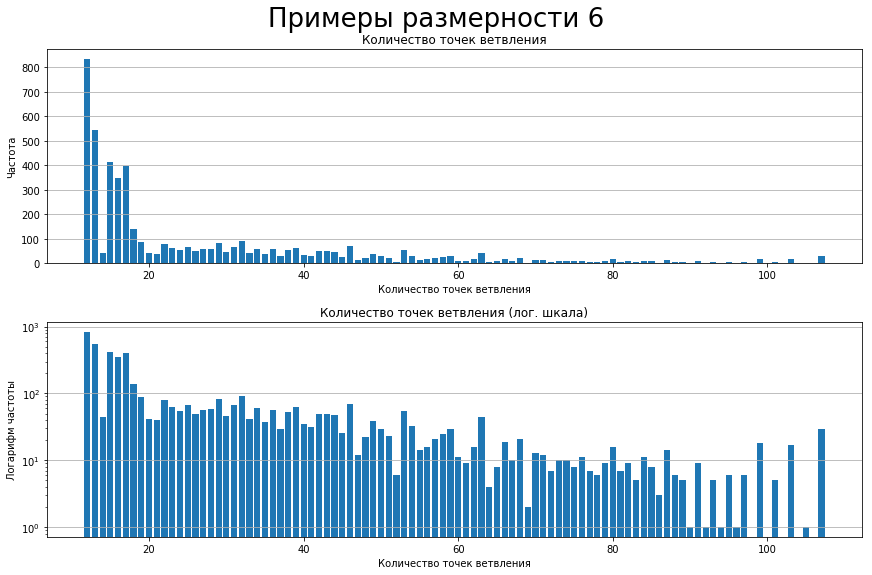

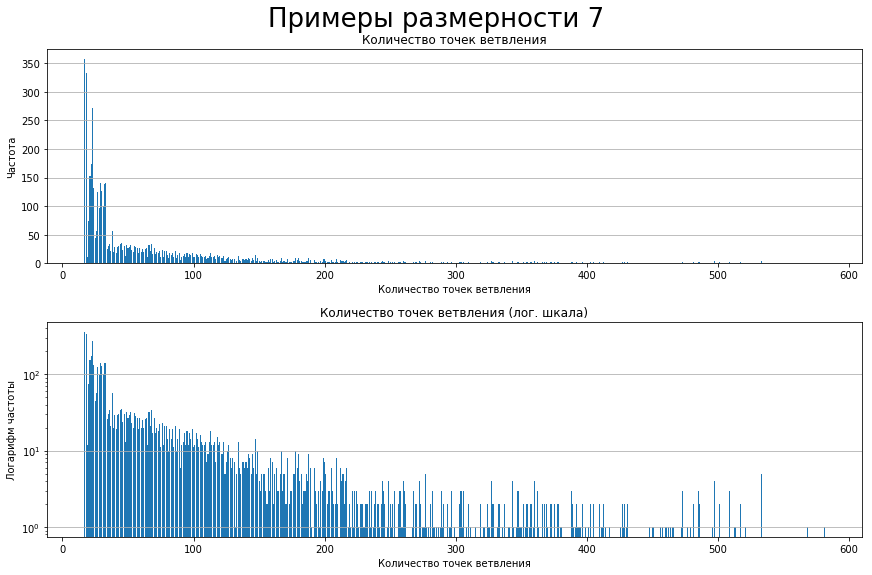

In [814]:
for i in range(4, 8):
    with open("afreq%s.json" % i, 'r') as f:
        d = json.load(f)
        x = list(map(int, d.keys()))
        y = list(map(int, d.values()))
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), constrained_layout=True)
        fig.suptitle("Примеры размерности %s" % i, fontsize=26)
        l_width = 1
        #if i > 5: l_width = (i-5.5)*10
        axes[0].bar(x, y)
        axes[0].set_title("Количество точек ветвления")
        axes[0].set_xlabel("Количество точек ветвления")
        axes[0].set_ylabel("Частота")
        axes[0].grid(axis='y')
        axes[1].bar(x, y, log=True)
        axes[1].set_title("Количество точек ветвления (лог. шкала)")
        axes[1].set_xlabel("Количество точек ветвления")
        axes[1].set_ylabel("Логарифм частоты")
        axes[1].grid(axis='y')

# Результаты для осн. алгоритма (мод. версия)

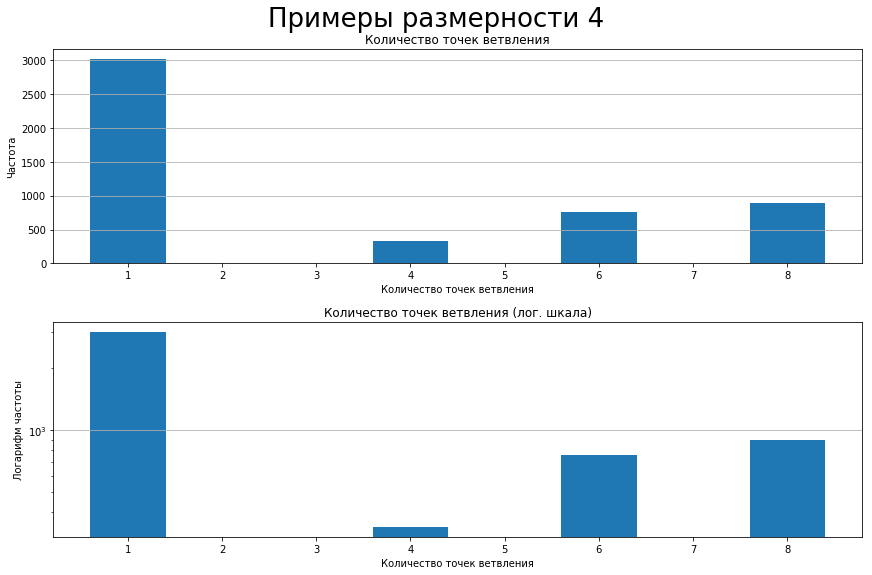

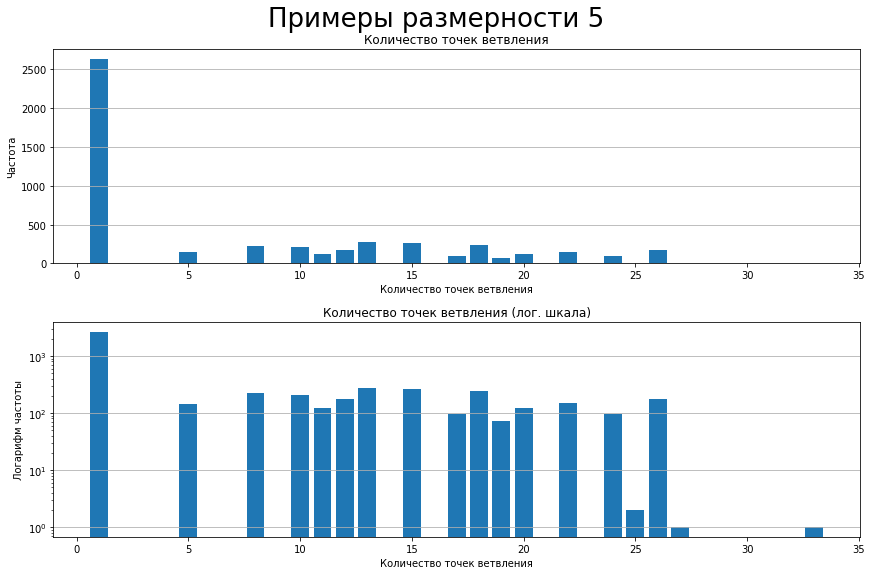

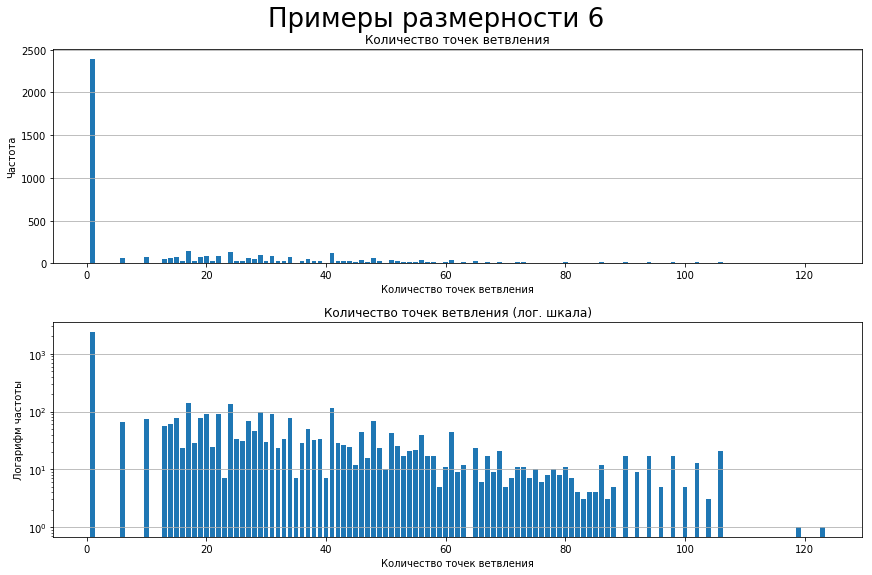

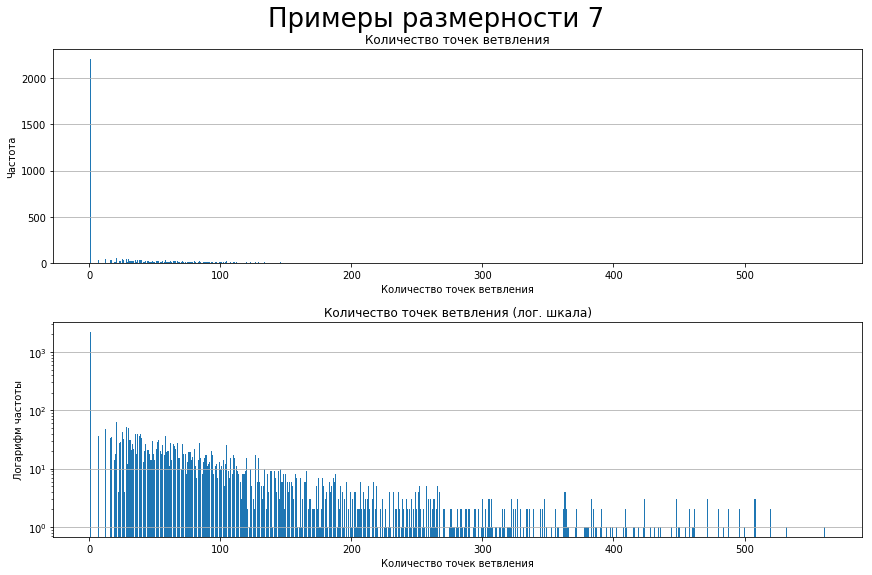

In [815]:
for i in range(4, 8):
    with open("mafreq%s.json" % i, 'r') as f:
        d = json.load(f)
        x = list(map(int, d.keys()))
        y = list(map(int, d.values()))
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), constrained_layout=True)
        fig.suptitle("Примеры размерности %s" % i, fontsize=26)
        l_width = 1
        #if i > 5: l_width = (i-5.5)*10
        axes[0].bar(x, y)
        axes[0].set_title("Количество точек ветвления")
        axes[0].set_xlabel("Количество точек ветвления")
        axes[0].set_ylabel("Частота")
        axes[0].grid(axis='y')
        axes[1].bar(x, y, log=True)
        axes[1].set_title("Количество точек ветвления (лог. шкала)")
        axes[1].set_xlabel("Количество точек ветвления")
        axes[1].set_ylabel("Логарифм частоты")
        axes[1].grid(axis='y')

# **Tardiness problem**
То же самое, что и выше, но теперь $\varphi_{j_i} = T_{j_i}(\pi)$, где $T = max(0, L_{j_i}(\pi))$

## Алгоритм решения двойственной задачи

In [1393]:
def dual(N, tau, B):
    pi_r = r(np.argsort(N, axis=0).transpose())
    bestL = float('inf')
    for i_k in pi_r:
        toDrop = B.copy()
        toDrop.append(i_k)
        i_l = remove(pi_r, toDrop)
        if len(i_l) != 0:
            i_l = i_l[0]
            pi_k = remove(pi_r, [i_l, i_k])
            pi_k = np.insert(pi_k, 0, i_l)
            pi_k = np.append(pi_k, i_k)
            #print(pi_k)
            if len(pi_k) != len(N):
                raise RuntimeError("Exception: len(pi_k) != len(N)")
            L_k = N[pi_k].T(i=None, tau=tau)
            if L_k < bestL:
                bestL = L_k
    return bestL 
        

## Алгоритмы проверки решения двойственной задачи

In [1383]:
def dual_brute(N, tau, B):
    """
    Dual alg bruteforce test with no respect to B
    """
    return max([min([p.T(i_k, tau) for p in map(TaskSet, permutations(N))]) for i_k, task in enumerate(N)])

In [1384]:
def dual_brute(N, tau, B):
    """
    Dual alg bruteforce test with respect to B
    """
    
    try:
        return max([min([pm.T(i_k, tau) for pm in map(TaskSet, permutations(N)) if (pm[0].array.tolist() not in N[B].array.tolist())]) for i_k, task in enumerate(N)])
    except ValueError: # todo: remove try-catch
        return float('inf')

## Основной алгоритм
В стандартной версии начальное значение $\pi^* = \emptyset$, в модифицированной: $\pi^* = \pi^r$ - все требования в порядке неубывания моментов поступления $r_j$.

In [1394]:
def main(N, tau=0, verbose=False, modified=False):
    b_counter = 0
    instances = [Instance(N, tau)]
    if modified: bestPi = list(range(len(N)))
    else: bestPi = []
    while len(instances) > 0:
        #print(len(instances))
        bestInstanceIndex, bestInstance = min(enumerate(instances), key=lambda x: x[1].nu) # + N[x[1].pi].L_max(tau))
        instances.pop(bestInstanceIndex)
        f = bestInstance.best_job()
        f_data = bestInstance[f]
        N1 = bestInstance.N.without(f)
        tau1 = max(r(f_data), bestInstance.tau) + p(f_data)
        B1 = []
        pi1 = bestInstance.pi.copy()
        pi1.append(N.find(f_data)[0])
        i1 = Instance(N1, tau1, pi1, B1)
        N2 = bestInstance.N
        tau2 = bestInstance.tau
        B2 = bestInstance.B.copy()
        B2.append(N2.find(f_data)[0]) #!
        pi2 = bestInstance.pi
        i2 = Instance(N2, tau2, pi2, B2)
        instances += [i1, i2]
        b_counter += 1
        #print(pi1)
        if len(pi1) == len(N):
            #print(N[bestPi].L_max(tau))
            #print(pi1)
            if N[pi1].T_max(tau) < N[bestPi].T_max(tau):
                bestPi = pi1.copy()
                if verbose: print(bestPi, '\tTmax =', N[bestPi].T_max(tau))
        #lb = len(instances)
        instances = [i for i in instances if i.nu < N[bestPi].T_max(tau)]
        #print(lb, len(instances))
    return bestPi, b_counter
        

## Проверка решений, предлагаемых основным алгоритмом

In [1395]:
def bruteforce(N, tau=0):
    best_L = N.T_max(tau)
    best_N = N.copy()
    for perm in permutations(N):
        s = TaskSet(perm)
        L = s.T_max(tau)
        if best_L == 0:
            return 0
        elif L < best_L:
            best_L = L
            best_N = s.copy()
    return best_L

Метод для парсинга примеров Shunji Tanaka

In [1396]:
def parse_str(s):
    s = np.array(s.replace(',', ' ').split(), dtype=int)
    s = s.reshape((len(s)//3, 3))
    return s

import glob
schedules = []
for fname in glob.glob("./tasks/*.txt"):
    file = open(fname, 'r')
    a = np.array(list(f.split() for f in file.readlines()[:-2])).astype(int)
    schedules.append(TaskSet(a))

In [1397]:
inds=1
res, c = main(schedules[inds], verbose=True)
schedules[inds][res].T_max(0)

KeyboardInterrupt: 

# Тестирование

## Проверка алгоритма решения двойственной задачи
(спойлер: что-то не так)

In [1352]:
for size in range(3, 6):
    correct = 0
    incorrect = 0
    print('processing size', size, end='... ')
    for i in range(500):
        s = TaskSet(size)
        B = list(np.random.randint(0, size, size=size-1))
        tau = random.randint(0, 1000)
        #tau=0
        nu = dual(s, tau, B)
        real_nu = dual_brute(s, tau, B)
        if nu == real_nu:
            correct += 1
        else:
            raise Exception("Incorrect")
            incorrect += 1
    print(correct, "correct\t", incorrect, "incorrect")

processing size 3... 

Exception: Incorrect

## Тестирование основного алгоритма

In [1380]:
for size in range(3, 6):
    correct = 0
    incorrect = 0
    print('processing size', size, end='... ')
    for i in range(500):
        N = TaskSet(size)
        res, c = main(N)
        res = N[res].T_max()
        bruteRes = bruteforce(N)
        if bruteRes == res:
            correct += 1
        else:
            incorrect += 1
    print(correct, "correct\t", incorrect, "incorrect")

processing size 3... 500 correct	 0 incorrect
processing size 4... 500 correct	 0 incorrect
processing size 5... 500 correct	 0 incorrect


## Тестирование основного алгоритма (мод. версия)

In [1379]:
for size in range(3, 6):
    correct = 0
    incorrect = 0
    print('processing size', size, end='... ')
    for i in range(500):
        N = TaskSet(size)
        res, c = main(N, modified=True)
        res = N[res].L_max()
        bruteRes = bruteforce(N)
        if bruteRes == res:
            correct += 1
        else:
            incorrect += 1
    print(correct, "correct\t", incorrect, "incorrect")

processing size 3... 500 correct	 0 incorrect
processing size 4... 500 correct	 0 incorrect
processing size 5... 500 correct	 0 incorrect


## Проверка производительности осн. алгоритма

In [797]:
for size in range(4, 8):
    results = {}
    for i in range(5000):
        s = TaskSet(size)
        bp, c = main(s)
        if c not in results.keys():
            results[c] = 1
        else:
            results[c] += 1
        if (i+1) % 100 == 0:
            plt.title("Количество точек ветвления для %s примеров размерности %s" % (i+1, size))
            plt.xlabel("Счётчик")
            plt.ylabel("Частота")
            plt.grid(axis='y')
            plt.bar(results.keys(), results.values(), width=1)
            plt.show()
            clear_output(wait=True)
    with open('afreq%s.json' % size, 'w') as f:
        json.dump(results, f)
    #plt.savefig('afreq%s.png' % size, dpi=300)

<Figure size 432x288 with 0 Axes>

## Проверка производительности осн. алгоритма (мод. версия)

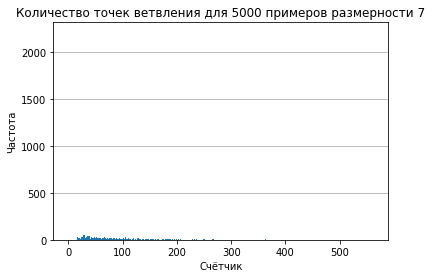

In [799]:
# !modified!
for size in range(4, 8):
    results = {}
    for i in range(5000):
        s = TaskSet(size)
        bp, c = main(s, modified=True)
        if c not in results.keys():
            results[c] = 1
        else:
            results[c] += 1
        if (i+1) % 100 == 0:
            plt.title("Количество точек ветвления для %s примеров размерности %s" % (i+1, size))
            plt.xlabel("Счётчик")
            plt.ylabel("Частота")
            plt.grid(axis='y')
            plt.bar(results.keys(), results.values(), width=1)
            plt.show()
            clear_output(wait=True)
    with open('mafreq%s.json' % size, 'w') as f:
        json.dump(results, f)
    #plt.savefig('mafreq%s.png' % size, dpi=300)

# Результаты для осн. алгоритма

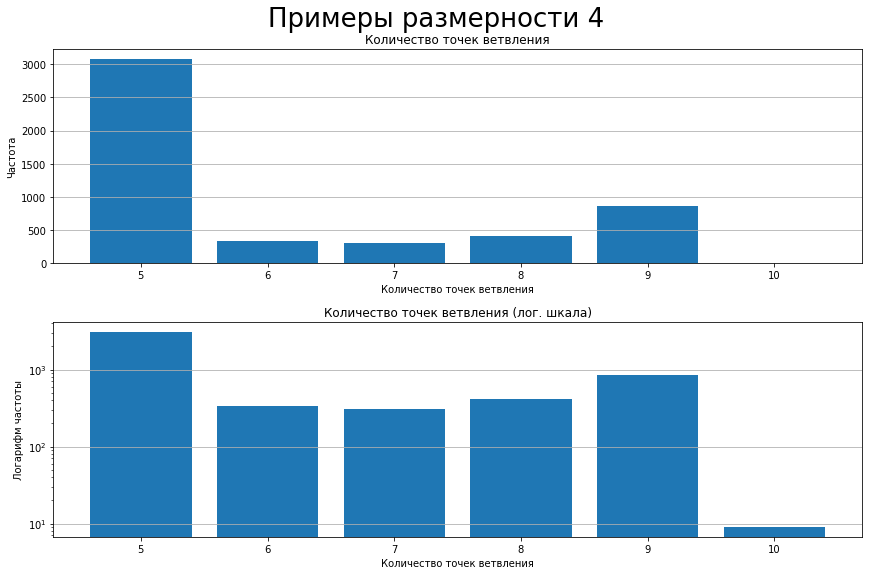

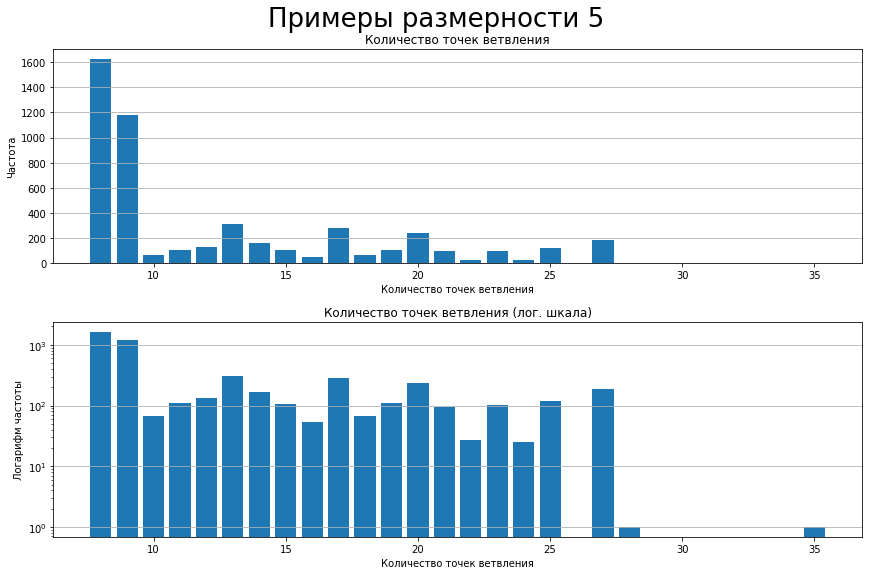

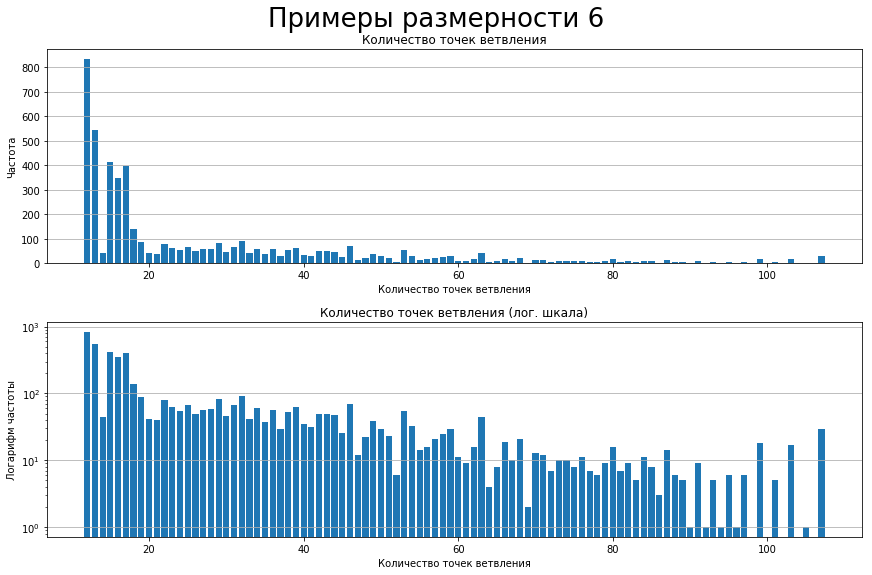

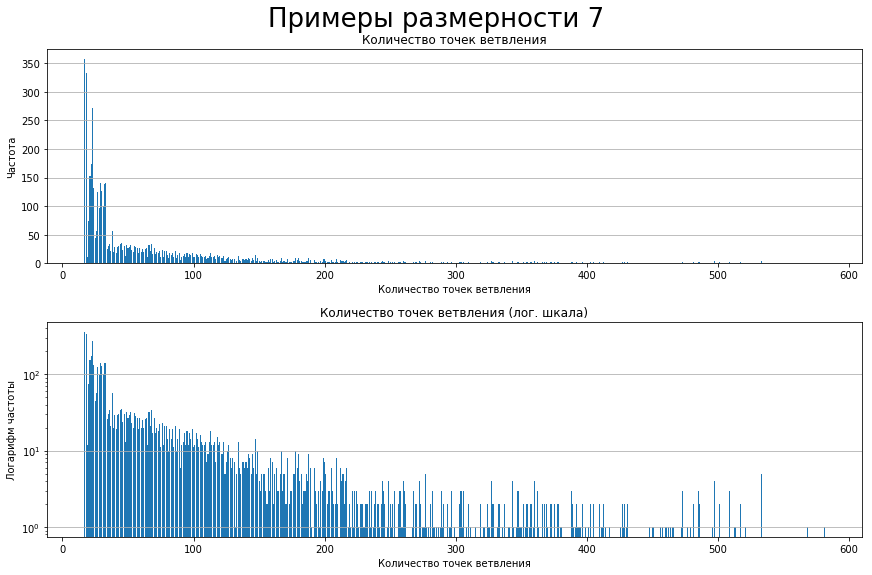

In [814]:
for i in range(4, 8):
    with open("afreq%s.json" % i, 'r') as f:
        d = json.load(f)
        x = list(map(int, d.keys()))
        y = list(map(int, d.values()))
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), constrained_layout=True)
        fig.suptitle("Примеры размерности %s" % i, fontsize=26)
        l_width = 1
        #if i > 5: l_width = (i-5.5)*10
        axes[0].bar(x, y)
        axes[0].set_title("Количество точек ветвления")
        axes[0].set_xlabel("Количество точек ветвления")
        axes[0].set_ylabel("Частота")
        axes[0].grid(axis='y')
        axes[1].bar(x, y, log=True)
        axes[1].set_title("Количество точек ветвления (лог. шкала)")
        axes[1].set_xlabel("Количество точек ветвления")
        axes[1].set_ylabel("Логарифм частоты")
        axes[1].grid(axis='y')

# Результаты для осн. алгоритма (мод. версия)

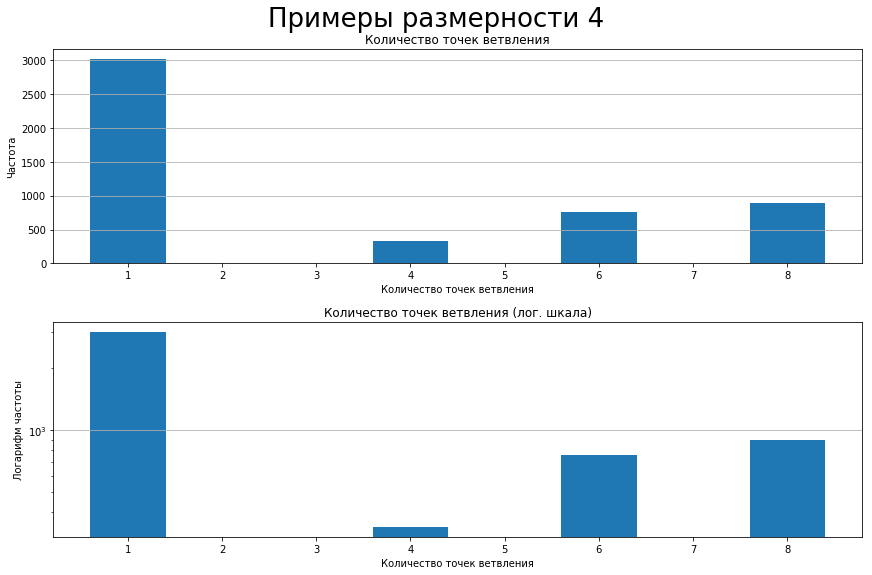

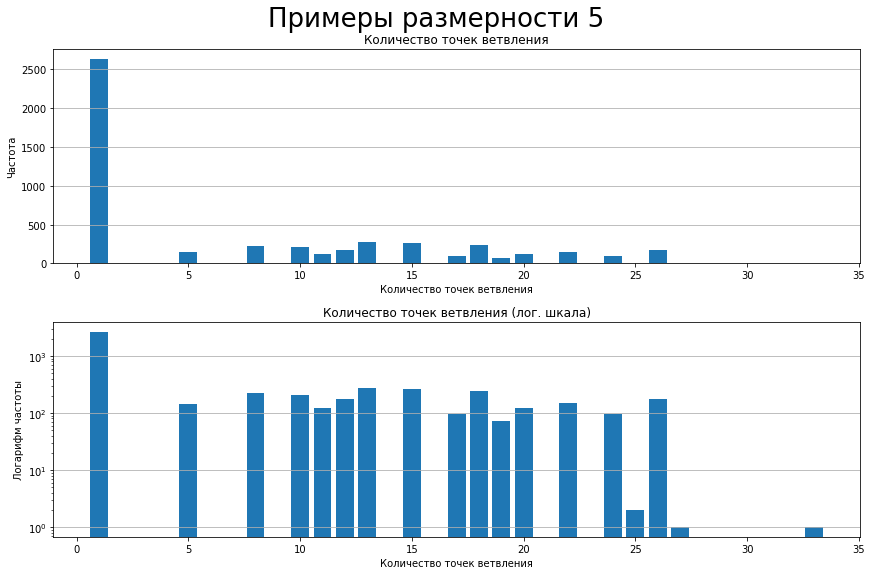

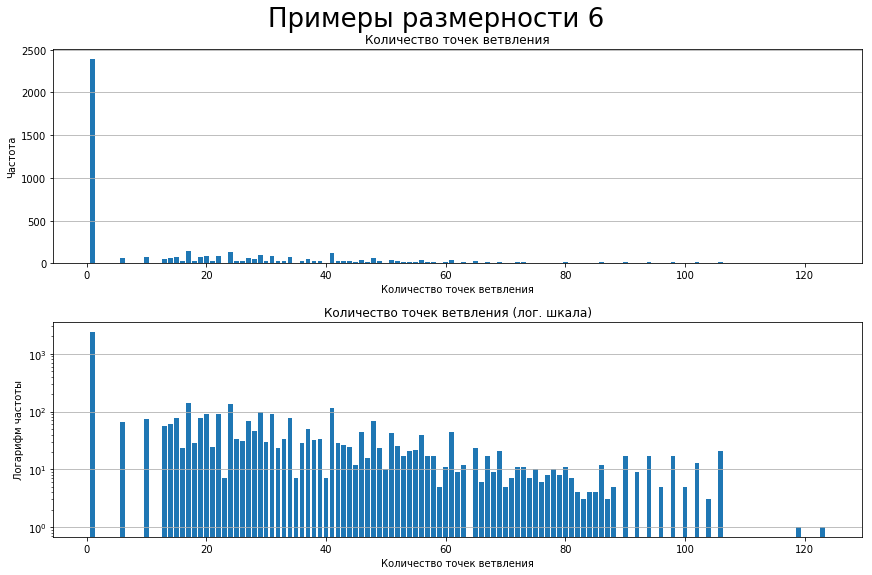

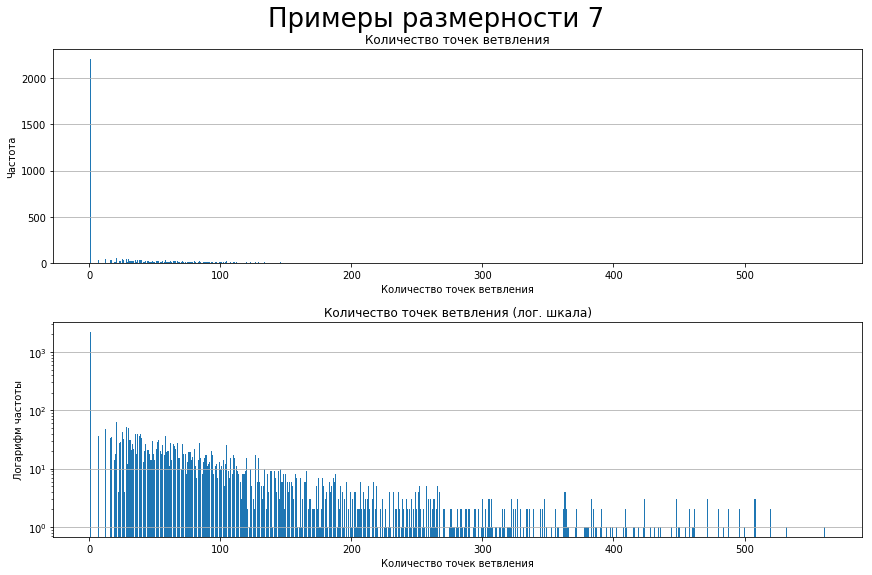

In [815]:
for i in range(4, 8):
    with open("mafreq%s.json" % i, 'r') as f:
        d = json.load(f)
        x = list(map(int, d.keys()))
        y = list(map(int, d.values()))
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), constrained_layout=True)
        fig.suptitle("Примеры размерности %s" % i, fontsize=26)
        l_width = 1
        #if i > 5: l_width = (i-5.5)*10
        axes[0].bar(x, y)
        axes[0].set_title("Количество точек ветвления")
        axes[0].set_xlabel("Количество точек ветвления")
        axes[0].set_ylabel("Частота")
        axes[0].grid(axis='y')
        axes[1].bar(x, y, log=True)
        axes[1].set_title("Количество точек ветвления (лог. шкала)")
        axes[1].set_xlabel("Количество точек ветвления")
        axes[1].set_ylabel("Логарифм частоты")
        axes[1].grid(axis='y')